In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import st_remux as st

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



%matplotlib inline

Using TensorFlow backend.
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/trial_env/l

In [2]:
# Config
highpath = 'EMG_data/high_fatigue_raw.csv'
lowpath = 'EMG_data/low_fatigue_raw.csv'

fs = 4000
win_len = 40

use_filter = 0   # weird results if we use python filtering

use_matlab_backend = 0

high = np.genfromtxt(highpath, delimiter=',')
low = np.genfromtxt(lowpath, delimiter=',')


In [3]:
if use_matlab_backend:
    print('Using MATLAB signal processing backend')
    # high_dir = 'datasets/high/'
    # low_dir = 'datasets/low/'

    high_dir = 'EMG_data/power_spectrum_for_cnn_input/high/'
    low_dir = 'EMG_data/power_spectrum_for_cnn_input/low/'

    def generate_3darray(directory):
        files = os.listdir(directory)
        dims = np.genfromtxt(directory + files[0], delimiter=',').shape
        length = len(files)
        arr = np.zeros((length, dims[0], dims[1]))

        for idx, val in enumerate(files):
            arr[idx] = np.genfromtxt(directory + val, delimiter=',')

        return arr

    hi = generate_3darray(high_dir)
    lo = generate_3darray(low_dir)
    
else: 
    print('Using native backend')
    hi = st.raw_to_arr(high, fs, win_len, 0)
    lo = st.raw_to_arr(low, fs, win_len, 0)

X = np.concatenate((hi, lo))

hi_Y = np.ones(len(hi), dtype=int)
lo_Y = np.zeros(len(lo), dtype=int)

Y = np.concatenate((hi_Y, lo_Y))

Using native backend


In [4]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1, random_state=13)

In [5]:
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Testing data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (3681, 16, 40) (3681,)
Testing data shape:  (410, 16, 40) (410,)


In [6]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)


Total number of outputs:  2
Output classes:  [0 1]


Text(0.5,1,'Ground Truth: 1')

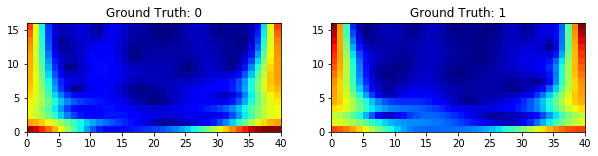

In [7]:
plt.figure(figsize=[10,2])

# Display first image in training set
plt.subplot(121)
plt.pcolormesh(train_X[0,:,:], cmap='jet')
plt.title("Ground Truth: {}".format(train_Y[0]))

# Display second image in testing set
plt.subplot(122)
plt.pcolormesh(test_X[1], cmap='jet')
plt.title("Ground Truth: {}".format(test_Y[1]))

In [8]:
ydim = train_X[0].shape[0]
xdim = train_X[0].shape[1]
train_X = train_X.reshape(-1, ydim, xdim, 1)
test_X = test_X.reshape(-1, ydim, xdim, 1)
train_X.shape, test_X.shape

((3681, 16, 40, 1), (410, 16, 40, 1))

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [10]:
# Change labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# See the difference?
print('Original label: ', train_Y[0])
print('After conversion to one-hot: ', train_Y_one_hot[0])

Original label:  0
After conversion to one-hot:  [1. 0.]


In [11]:
train_Y_one_hot.shape

(3681, 2)

In [12]:
# Partition data for 80% training and 20% validation
# should reduce overfitting and boost test performance

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)

train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((2944, 16, 40, 1), (737, 16, 40, 1), (2944, 2), (737, 2))

In [13]:
# let's get down to business
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [14]:
batch_size = 64
epochs = 50
num_classes = nClasses

In [24]:
emg_model = Sequential()
emg_model.add(
    Conv2D(
        32, 
        kernel_size=(3, 3), 
        activation='linear', 
        input_shape=(ydim, xdim, 1), 
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.25))
emg_model.add(
    Conv2D(
        64,
        (3, 3),
        activation='linear',
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.25))
emg_model.add(
    Conv2D(
        128,
        (3, 3),
        activation='linear',
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.4))
emg_model.add(Flatten())
emg_model.add(Dense(128, activation='linear'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(Dropout(0.3))
emg_model.add(Dense(num_classes, activation='softmax'))

In [25]:
emg_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
emg_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 16, 40, 32)        320       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 40, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 20, 32)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 20, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 20, 64)         18496     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 20, 64)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 10, 64)        

In [27]:
history_emg = emg_model.fit(train_X,train_label,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_X, valid_label))

Train on 2944 samples, validate on 737 samples
Epoch 1/50
2944/2944 [==============================] - 4s 2ms/step - loss: 0.6923 - accuracy: 0.5109 - val_loss: 0.6889 - val_accuracy: 0.4763
Epoch 2/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6813 - accuracy: 0.5418 - val_loss: 0.6820 - val_accuracy: 0.5550
Epoch 3/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6871 - accuracy: 0.5194 - val_loss: 0.6780 - val_accuracy: 0.5685
Epoch 4/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6794 - accuracy: 0.5543 - val_loss: 0.6822 - val_accuracy: 0.5617
Epoch 5/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6767 - accuracy: 0.5625 - val_loss: 0.6756 - val_accuracy: 0.5550
Epoch 6/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6781 - accuracy: 0.5537 - val_loss: 0.6745 - val_accuracy: 0.5672
Epoch 7/50
2944/2944 [==============================] - 3s 1ms/step - loss: 0.6754 - accu

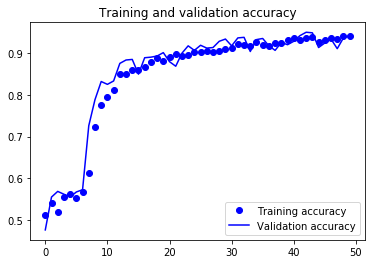

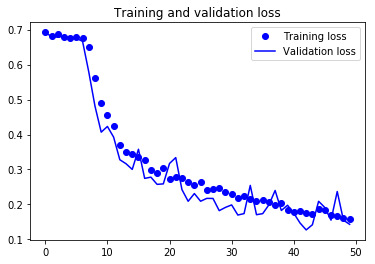

In [30]:
accuracy = history_emg.history['accuracy']
val_accuracy = history_emg.history['val_accuracy']
loss = history_emg.history['loss']
val_loss = history_emg.history['val_loss']
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, 'bo', label='Training accuracy')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [51]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(train_X,train_label, batch_size=256)
val_batches = gen.flow(valid_X, valid_label, batch_size=256)

In [52]:
history_emg = emg_model.fit_generator(batches, steps_per_epoch=2944//64, epochs=60,
                    validation_data=val_batches, validation_steps=737//64, use_multiprocessing=True)

Epoch 1/60
46/46 [==============================] - 13s 272ms/step - loss: 0.1073 - accuracy: 0.9609 - val_loss: 0.1278 - val_accuracy: 0.9589
Epoch 2/60
46/46 [==============================] - 13s 275ms/step - loss: 0.1127 - accuracy: 0.9574 - val_loss: 0.0686 - val_accuracy: 0.9632
Epoch 3/60
46/46 [==============================] - 13s 280ms/step - loss: 0.1126 - accuracy: 0.9586 - val_loss: 0.1875 - val_accuracy: 0.9603
Epoch 4/60
46/46 [==============================] - 13s 279ms/step - loss: 0.1102 - accuracy: 0.9599 - val_loss: 0.0896 - val_accuracy: 0.9647
Epoch 5/60
46/46 [==============================] - 13s 278ms/step - loss: 0.1071 - accuracy: 0.9597 - val_loss: 0.1529 - val_accuracy: 0.9580
Epoch 6/60
46/46 [==============================] - 13s 280ms/step - loss: 0.1135 - accuracy: 0.9567 - val_loss: 0.0514 - val_accuracy: 0.9721
Epoch 7/60
46/46 [==============================] - 12s 270ms/step - loss: 0.1030 - accuracy: 0.9607 - val_loss: 0.0591 - val_accuracy: 0.9655

Epoch 58/60
46/46 [==============================] - 13s 288ms/step - loss: 0.0803 - accuracy: 0.9702 - val_loss: 0.1252 - val_accuracy: 0.9559
Epoch 59/60
46/46 [==============================] - 13s 293ms/step - loss: 0.0801 - accuracy: 0.9699 - val_loss: 0.0919 - val_accuracy: 0.9577
Epoch 60/60
46/46 [==============================] - 14s 298ms/step - loss: 0.0792 - accuracy: 0.9718 - val_loss: 0.0857 - val_accuracy: 0.9677


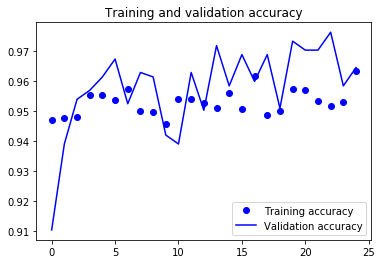

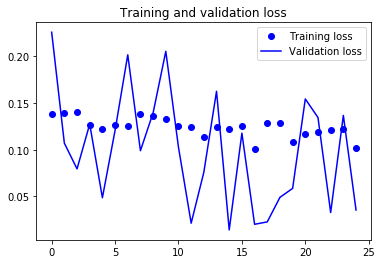

In [43]:
accuracy = history_emg.history['accuracy']
val_accuracy = history_emg.history['val_accuracy']
loss = history_emg.history['loss']
val_loss = history_emg.history['val_loss']
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, 'bo', label='Training accuracy')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()